# Final Project: Climate Analysis and Prediction

## 1. Problem Statement, Motivation, Research Goals:

Global climate change and its impact on human life has become one of our era's greatest challenges. Despite the urgency, data science has had little impact on furthering our understanding of our planet in spite of the abundance of climate data. 
A lot remains to be understood about our planet and the physical processes that govern it to effectively answer questions about global climate change and its societal impacts. It has been proposed that given the abundance of climate data from different regression models observations and different analysis, we may close some of these knowledge gaps by directly learning from these large climate datasets.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas_profiling as pp
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.colors import ListedColormap

/Users/rohit1/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


## 2. Data Source and Description:

Where/how do you get the data?

In [2]:
# read file
originaldata = pd.read_csv("./DelhiWeather.csv")
print(originaldata.shape)
originaldata.head()

(100990, 20)


Date Condition  Dew Point  Fog  Hail  Heat Index  Humidity  \
0  19961101-11:00     Smoke        9.0    0     0         NaN      27.0   
1  19961101-12:00     Smoke       10.0    0     0         NaN      32.0   
2  19961101-13:00     Smoke       11.0    0     0         NaN      44.0   
3  19961101-14:00     Smoke       10.0    0     0         NaN      41.0   
4  19961101-16:00     Smoke       11.0    0     0         NaN      47.0   

   Precipitation  Pressure  Rain  Snow  Temperature  Thunder  Tornado  \
0            NaN    1010.0     0     0         30.0        0        0   
1            NaN   -9999.0     0     0         28.0        0        0   
2            NaN   -9999.0     0     0         24.0        0        0   
3            NaN    1010.0     0     0         24.0        0        0   
4            NaN    1011.0     0     0         23.0        0        0   

   Visibility  Wind Direction Degrees Wind Direction Cardinal  Wind Gust  \
0         5.0                   280.0                    West        NaN   
1         NaN                     0.0                   North        NaN   
2         NaN                     0.0                   North        NaN   
3         2.0                     0.0                   North        NaN   
4         1.2                     0.0                   North        NaN   

   Wind Chill  Wind Speed  
0         NaN         7.4  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         0.0

## 3. Literature Review and References:

This could include noting any key papers, texts, or websites that you have used to develop your modeling approach, as well as what others have done on this problem in the past. You must properly credit sources.

## 4. Preliminary EDA:

In [3]:
# First I drop columns that are not complete or not useful
data = originaldata.drop(['Precipitation', 'Wind Chill', 'Wind Direction Cardinal', 'Wind Gust', 'Heat Index', 'Wind Direction Degrees'], axis=1)
# Pressure -9999 is missing data so I replace with Nan and we will use imputation later
data['Pressure'] = data['Pressure'].replace(-9999.0, np.NaN)
# Four of the temperature observations are in Fahrenheit so we must convert
data.at[91391, 'Temperature'] = (float(5)/9) * (data.at[91391, 'Temperature'] - 32)
data.at[11084, 'Temperature'] = (float(5)/9) * (data.at[11084, 'Temperature'] - 32)
data.at[12951, 'Temperature'] = (float(5)/9) * (data.at[12951, 'Temperature'] - 32)
data.at[68077, 'Temperature'] = (float(5)/9) * (data.at[68077, 'Temperature'] - 32)
# One of the visibility observations is in meters instead of kilometers so we must convert
data.at[58253, 'Visibility'] /= 1000
# Some of the pressure observations are so high or low they must be mistakes so we will drop them
# Some of the wind speed observations are so high they must be mistakes so we will drop them
# Some of the humidity observations are above 100% so we will drop them
# Some of the visibility observations are 10 times higher than normal so we will divide them
for index, row in data.iterrows():
    if data.at[index, 'Pressure'] < 900 or data.at[index, 'Pressure'] > 1200:
        data.at[index, 'Pressure'] = np.NaN
    if data.at[index, 'Wind Speed'] > 300:
        data.at[index, 'Wind Speed'] = np.NaN
    if data.at[index, 'Humidity'] > 100:
        data.at[index, 'Wind Speed'] = np.NaN
    if data.at[index, 'Visibility'] > 10:
        data.at[index, 'Visibility'] /= 10
pp.ProfileReport(data)

## 5. Modeling Process:

## Imputation and Interpolation

In [4]:
data.isnull().sum()

Date              0
Condition        72
Dew Point       621
Fog               0
Hail              0
Humidity        757
Pressure       1125
Rain              0
Snow              0
Temperature     673
Thunder           0
Tornado           0
Visibility     4428
Wind Speed     2366
dtype: int64

Variable 'Condition' will require most frequent value imputation because it is categorical, and all the numerical data will require interpolation.

In [5]:
nullFeatures = [feature for feature, numNull in data.isnull().sum().iteritems() if numNull > 0]
nullFeatures

['Condition',
 'Dew Point',
 'Humidity',
 'Pressure',
 'Temperature',
 'Visibility',
 'Wind Speed']

In [6]:
for n in nullFeatures[1:]: # Skip Condition for interpolation
    data[n] = data[n].interpolate()
data.isnull().sum()

Date            0
Condition      72
Dew Point       0
Fog             0
Hail            0
Humidity        0
Pressure        0
Rain            0
Snow            0
Temperature     0
Thunder         0
Tornado         0
Visibility      0
Wind Speed      0
dtype: int64

In [7]:
print (data["Condition"].value_counts())

Haze                             47602
Smoke                            20760
Mist                              9375
Clear                             3129
Widespread Dust                   2856
Fog                               2760
Scattered Clouds                  2209
Partly Cloudy                     2091
Shallow Fog                       1860
Mostly Cloudy                     1537
Light Rain                        1302
Partial Fog                       1031
Patches of Fog                     901
Thunderstorms and Rain             486
Heavy Fog                          421
Light Drizzle                      414
Rain                               394
Unknown                            383
Blowing Sand                       378
Overcast                           326
Thunderstorm                       192
Light Thunderstorms and Rain       176
Drizzle                            112
Light Thunderstorm                  64
Light Fog                           64
Heavy Rain               

Haze is the most common so we will impute conditions using Haze.

In [8]:
data['Condition'] = data['Condition'].fillna('Haze')
data.isnull().sum()

Date           0
Condition      0
Dew Point      0
Fog            0
Hail           0
Humidity       0
Pressure       0
Rain           0
Snow           0
Temperature    0
Thunder        0
Tornado        0
Visibility     0
Wind Speed     0
dtype: int64

Now there are no more null values so we can do supervised and unsupervised learning.

### Association Analysis

In [9]:
# I tried using all conditions but apriori is 2^n and 51 variables takes too long so I must decrease this number
# Before converting weather condition to boolean we must combine similar conditions like light haze and haze
data['Condition'] = data['Condition'].replace('Light Haze', 'Haze')
data['Condition'] = data['Condition'].replace('Light Fog', 'Fog')
data['Condition'] = data['Condition'].replace('Heavy Fog', 'Fog')
data['Condition'] = data['Condition'].replace('Patches of Fog', 'Fog')
data['Condition'] = data['Condition'].replace('Partial Fog', 'Fog')
data['Condition'] = data['Condition'].replace('Shallow Fog', 'Fog')
data['Condition'] = data['Condition'].replace('Light Thunderstorms and Rain', 'Thunderstorms and Rain')
data['Condition'] = data['Condition'].replace('Heavy Thunderstorms and Rain', 'Thunderstorms and Rain')
data['Condition'] = data['Condition'].replace('Light Thunderstorm', 'Thunderstorm')
data['Condition'] = data['Condition'].replace('Light Rain', 'Rain')
data['Condition'] = data['Condition'].replace('Rain Showers', 'Rain')
data['Condition'] = data['Condition'].replace('Light Rain Showers', 'Rain')
data['Condition'] = data['Condition'].replace('Heavy Rain', 'Rain')
data['Condition'] = data['Condition'].replace('Light Drizzle', 'Rain')
data['Condition'] = data['Condition'].replace('Drizzle', 'Rain')
data['Condition'] = data['Condition'].replace('Mostly Cloudy', 'Overcast')
data['Condition'] = data['Condition'].replace('Scattered Clouds', 'Clear')
data['Condition'] = data['Condition'].replace('Heavy Thunderstorms with Hail', 'Thunderstorms with Hail')
data['Condition'] = data['Condition'].replace('Light Hail Showers', 'Hail')
associationData = data

Let us visualize the most frequent conditions using a word cloud.

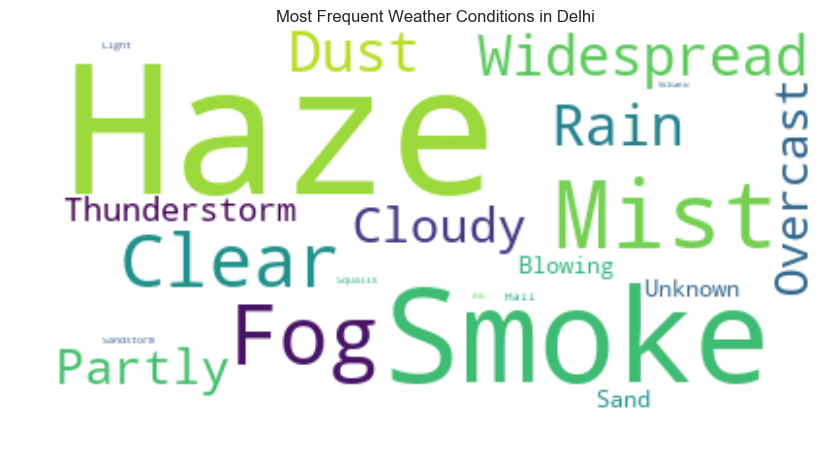

In [10]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color="#FFFFFF", collocations=False).generate(' '.join(list(data['Condition'])))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Frequent Weather Conditions in Delhi')
plt.axis('off')
plt.show()

In [11]:
# Now I convert the condition to booleans using get dummies one hot encoding
categories = pd.get_dummies(associationData, columns=['Condition'], prefix=['Condition']).drop(list(set(associationData.columns)-set(['Condition'])), axis=1)

In [12]:
# Next I drop the conditon unknown which is not useful
categories = categories.drop(['Condition_Unknown'], axis=1)
for index, row in categories.iterrows():
    # I drop Thunderstorms and Rain and instead make Rain true and Thunderstorm true also
    if categories.at[index,'Condition_Thunderstorms and Rain'] == 1:
        categories.at[index,'Condition_Rain'] = 1
        categories.at[index,'Condition_Thunderstorm'] = 1
    # I drop Thunderstorms and Hail and instead make Hail true and Thunderstorm true also
    if categories.at[index,'Condition_Thunderstorms with Hail'] == 1:
        categories.at[index,'Condition_Hail'] = 1
        categories.at[index,'Condition_Thunderstorm'] = 1
# Now I can remove these categories
categories = categories.drop(['Condition_Thunderstorms with Hail'], axis=1)
categories = categories.drop(['Condition_Thunderstorms and Rain'], axis=1)

In [13]:
size = len(categories)
frequencies = {}
for category in list(categories.columns):
    frequencies[category] = categories[category].sum()/size
frequencies = pd.DataFrame.from_dict(frequencies, orient='index', columns=['Frequency'])
categories = categories.drop(list(frequencies[frequencies['Frequency'] < .0001].index), axis=1)
# I drop categories that are found in less than 0.01% of the observations
frequencies.sort_values(by=['Frequency'], ascending=False)
data['Condition'] = data['Condition'].replace('Unknown', 'Other')
for n in list(frequencies[frequencies['Frequency'] < .0001].index):
    data['Condition'] = data['Condition'].replace(n[10:], 'Other')

In [14]:
booleanFeatures = associationData.drop(['Hail','Thunder','Fog','Rain','Condition','Date','Dew Point','Humidity','Pressure','Temperature','Visibility','Wind Speed'], axis=1)
# Now I add the boolean features from the dataset
booleanFeatures = pd.concat([booleanFeatures,categories], axis=1)
# This merges the data into one data frame
print(booleanFeatures.shape)
#pp.ProfileReport(booleanFeatures)

(100990, 14)


Apriori algorithm proceeds by identifying the frequent individual items in the database 
and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database. 
The frequent item sets determined by Apriori can be used to determine association rules 
which highlight general trends in the database.

In [15]:
frequencies = apriori(booleanFeatures, min_support=0.0, use_colnames=True)
# I calculate frequencies of item sets
frequencies = frequencies[frequencies.support != 0.0]
frequencies.sort_values(by=['support'], ascending=False)
# Frequencies for single items is not useful for rule generation.
# Therefore the most frequent pairs of itemsets which occured together matters for rule generation

support                                  itemsets
6    0.472106                          (Condition_Haze)
11   0.205565                         (Condition_Smoke)
7    0.092831                          (Condition_Mist)
4    0.069680                           (Condition_Fog)
3    0.052857                         (Condition_Clear)
10   0.029122                          (Condition_Rain)
13   0.028280               (Condition_Widespread Dust)
9    0.020705                 (Condition_Partly Cloudy)
8    0.018447                      (Condition_Overcast)
12   0.009427                  (Condition_Thunderstorm)
100  0.006773  (Condition_Rain, Condition_Thunderstorm)
2    0.003743                  (Condition_Blowing Sand)
5    0.000129                          (Condition_Hail)
75   0.000119  (Condition_Thunderstorm, Condition_Hail)
1    0.000020                                 (Tornado)
23   0.000010                    (Condition_Rain, Snow)
0    0.000010                                    (Snow)

In [16]:
rules = association_rules(frequencies, min_threshold=0.0)
rules.sort_values(by=['confidence'], ascending=False)

antecedents               consequents  antecedent support  \
1                    (Snow)          (Condition_Rain)            0.000010   
3          (Condition_Hail)  (Condition_Thunderstorm)            0.000129   
5  (Condition_Thunderstorm)          (Condition_Rain)            0.009427   
4          (Condition_Rain)  (Condition_Thunderstorm)            0.029122   
2  (Condition_Thunderstorm)          (Condition_Hail)            0.009427   
0          (Condition_Rain)                    (Snow)            0.029122   

   consequent support   support  confidence       lift  leverage  conviction  
1            0.029122  0.000010    1.000000  34.338660  0.000010         inf  
3            0.009427  0.000119    0.923077  97.921784  0.000118   12.877453  
5            0.029122  0.006773    0.718487  24.671895  0.006498    3.448792  
4            0.009427  0.006773    0.232574  24.671895  0.006498    1.290774  
2            0.000129  0.000119    0.012605  97.921784  0.000118    1.012636  
0            0.000010  0.000010    0.000340  34.338660  0.000010    1.000330

After using apriori to get item set frequencies and association rules generation to get rules, there are six rules and some are more confidence than others. We can say with 92.3% confidence that if we observe hail then we will also observe thunder. We can say with 71.8% confidence that if we observe thunder then we will also observe rain.

What we have done is use the apriori algorithm to find the most frequent pairs of features that occur together, then calculate the confidence P(A&&B)/P(A). High confidence means A -> B is a good rule.

## Visualizing trends independent of seasonality

There will be trends in the data but it is periodic so we must normalize for seasons.

In [17]:
tempData = pd.DataFrame(data[['Date','Temperature','Dew Point','Humidity','Pressure','Visibility','Wind Speed']])

In [18]:
date = pd.to_datetime(data['Date'])

In [19]:
firstTime = date[0]
for n, d in date.iteritems():
    # Convert date to number of hours since first observation so the graph will be over time
    tempData.at[n, 'Date'] = float((d - firstTime).total_seconds())/3600

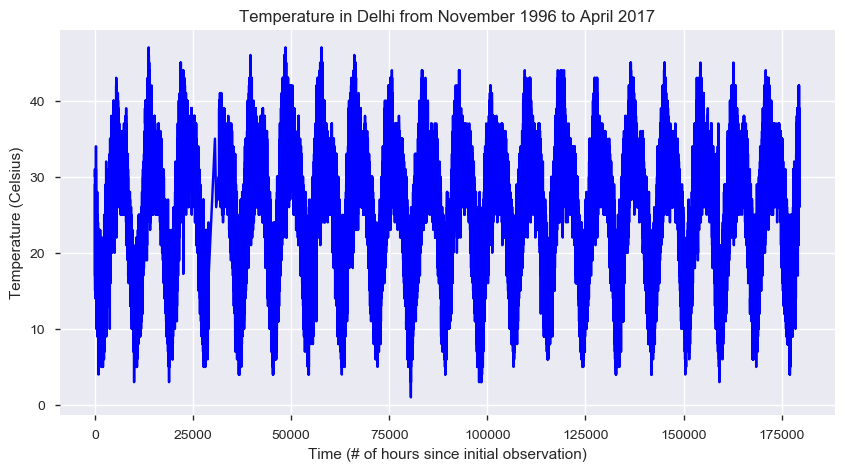

In [20]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Temperature'], c='b')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature in Delhi from November 1996 to April 2017')
plt.show()

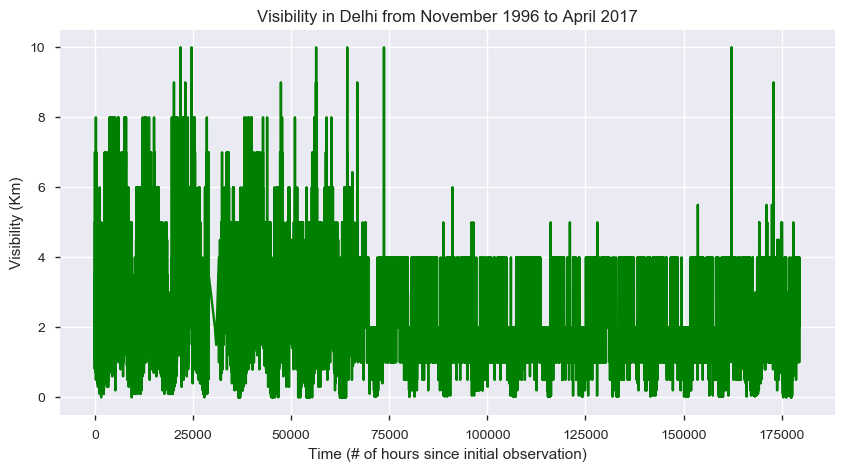

In [21]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Visibility'], c='g')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Visibility (Km)')
plt.title('Visibility in Delhi from November 1996 to April 2017')
plt.show()

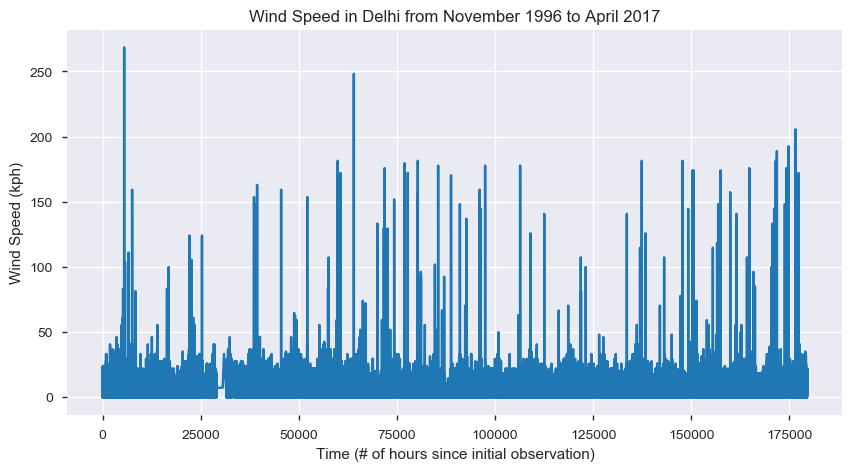

In [22]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Wind Speed'])
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Wind Speed (kph)')
plt.title('Wind Speed in Delhi from November 1996 to April 2017')
plt.show()

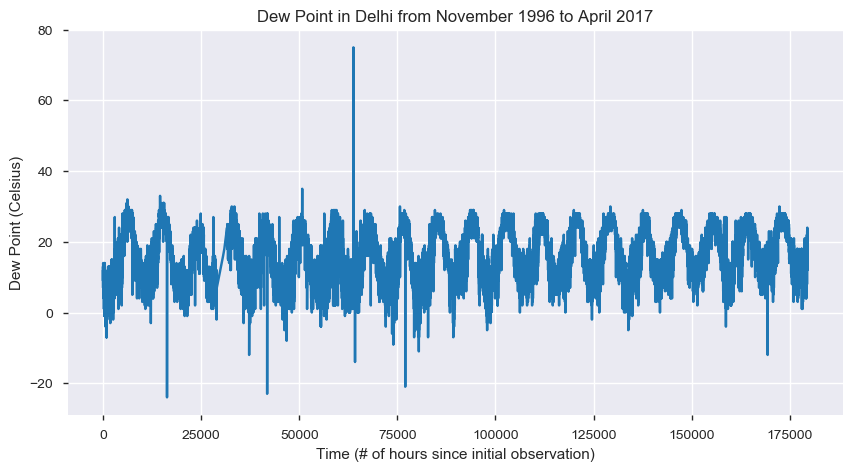

In [23]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Dew Point'])
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point in Delhi from November 1996 to April 2017')
plt.show()

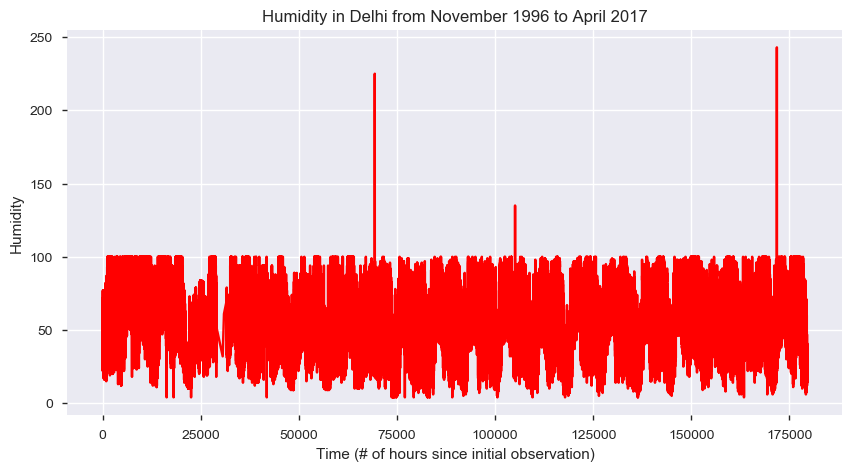

In [24]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Humidity'], c='r')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Humidity')
plt.title('Humidity in Delhi from November 1996 to April 2017')
plt.show()

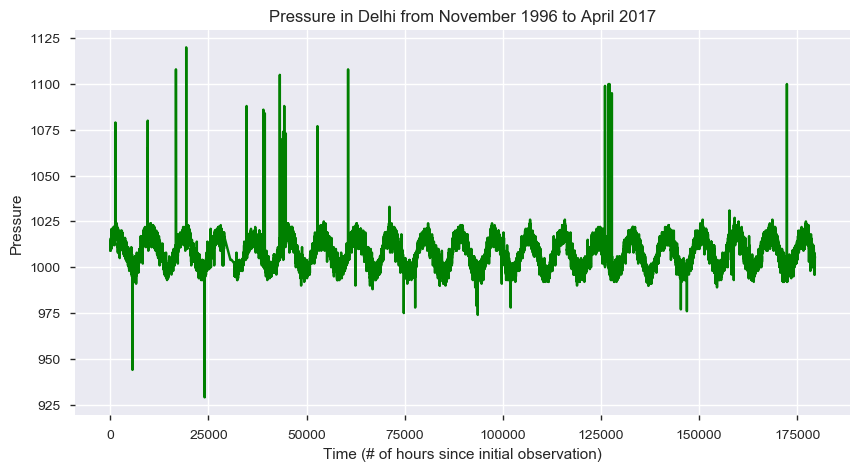

In [25]:
plt.figure(figsize=(10,5))
plt.plot(tempData['Date'], tempData['Pressure'], c='g')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Pressure')
plt.title('Pressure in Delhi from November 1996 to April 2017')
plt.show()

Some of these features will benefit from seasonality normalization and some would not. Pressure and Dew Point and Temperature seem periodical but Visibility and Humidity and Wind Speed are not so periodical.

In [26]:
resultTemperature = seasonal_decompose(list(tempData['Temperature']), model='additive', freq=8760)
resultPressure = seasonal_decompose(list(tempData['Pressure']), model='additive', freq=8760)
resultDewPoint = seasonal_decompose(list(tempData['Dew Point']), model='additive', freq=8760)
# I use seasonal decomposition to find the trends independent of seasonal periodicity

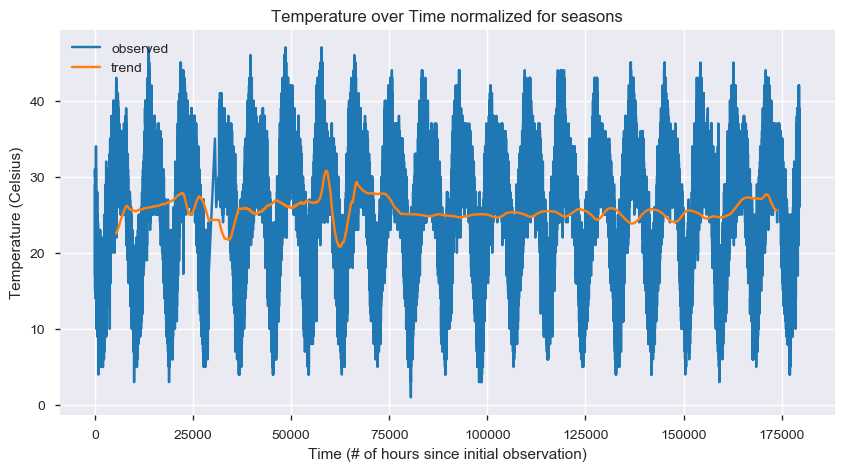

In [27]:
# visualize results
plt.figure(figsize=(10,5))
#plt.plot(list(tempData['Date']), series, label='data')
plt.plot(list(tempData['Date']), resultTemperature.observed, label='observed')
plt.plot(list(tempData['Date']), resultTemperature.trend, label='trend')
plt.legend(loc='upper left')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature over Time normalized for seasons')
plt.show()

This chart shows the original data in blue, and the trend after normalizing for seasons (i.e getting rid of useless data) in orange. From this we can see that there was an abnormally cold Winter in Delhi in 2003-2004. This does not show the deadly heat wave of 2015 because it is smooth and ignores spikes.

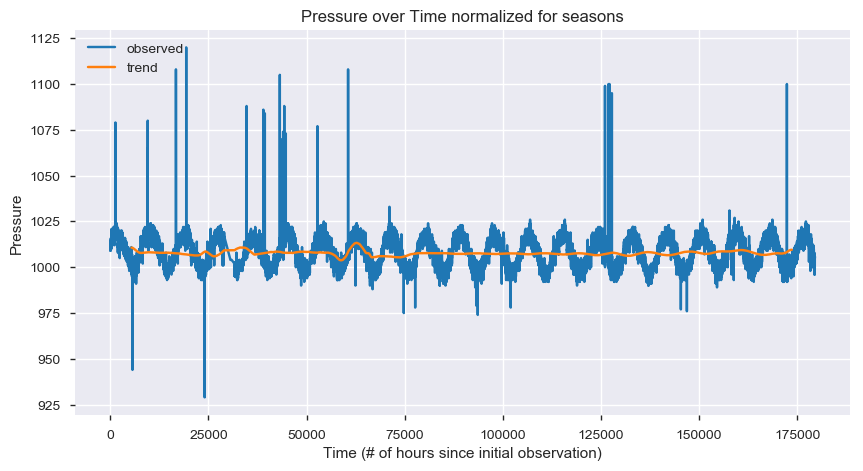

In [28]:
# visualize results
plt.figure(figsize=(10,5))
#plt.plot(list(tempData['Date']), series, label='data')
plt.plot(list(tempData['Date']), resultPressure.observed, label='observed')
plt.plot(list(tempData['Date']), resultPressure.trend, label='trend')
plt.legend(loc='upper left')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Pressure')
plt.title('Pressure over Time normalized for seasons')
plt.show()

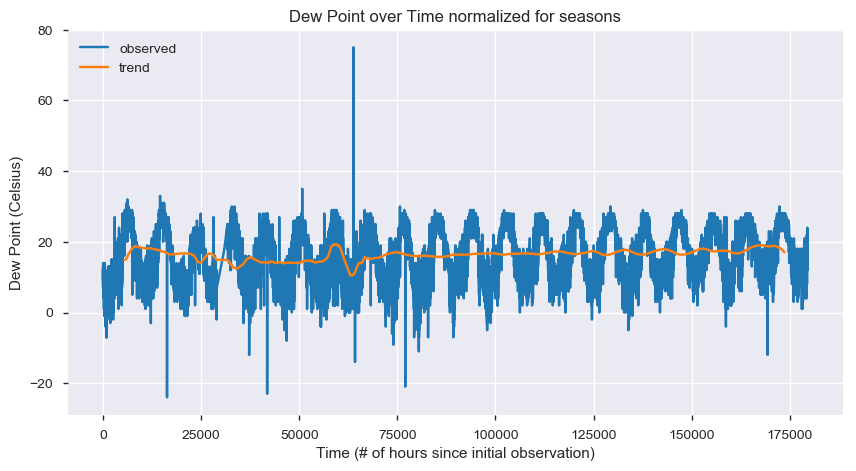

In [29]:
# visualize results
plt.figure(figsize=(10,5))
#plt.plot(list(tempData['Date']), series, label='data')
plt.plot(list(tempData['Date']), resultDewPoint.observed, label='observed')
plt.plot(list(tempData['Date']), resultDewPoint.trend, label='trend')
plt.legend(loc='upper left')
plt.xlabel('Time (# of hours since initial observation)')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point over Time normalized for seasons')
plt.show()

## Regression

In [30]:
# I will predict temperature and visibility separately
Xtemp = pd.concat([data.drop(['Date','Temperature','Condition','Fog','Hail','Rain','Thunder'],axis=1), categories], axis=1)
Ytemp = pd.DataFrame(data['Temperature'])
Xvis = pd.concat([data.drop(['Date','Visibility','Condition','Fog','Hail','Rain','Thunder'],axis=1), categories], axis=1)
Yvis = pd.DataFrame(data['Visibility'])

In [31]:
# Split into training and testing
xTrainTemp, xTestTemp, yTrainTemp, yTestTemp = train_test_split(Xtemp, Ytemp, random_state=int(time.time()), test_size=0.10)
xTrainVis, xTestVis, yTrainVis, yTestVis = train_test_split(Xvis, Yvis, random_state=int(time.time()), test_size=0.10)

### Linear Regression

In [32]:
lrTemp = LinearRegression().fit(xTrainTemp, yTrainTemp)
lrVis = LinearRegression().fit(xTrainVis, yTrainVis)

print("Training set score for temperature: {:.2f}".format(lrTemp.score(xTrainTemp, yTrainTemp)))
print("Test set score for temperature: {:.2f}".format(lrTemp.score(xTestTemp, yTestTemp)))
print("Training set score for visibility: {:.2f}".format(lrVis.score(xTrainVis, yTrainVis)))
print("Test set score for visibility: {:.2f}".format(lrVis.score(xTestVis, yTestVis)))

Training set score for temperature: 0.94
Test set score for temperature: 0.94
Training set score for visibility: 0.49
Test set score for visibility: 0.48


### Ridge Regression

In [33]:
ridgeTemp = Ridge().fit(xTrainTemp, yTrainTemp)
ridgeVis = Ridge().fit(xTrainVis, yTrainVis)

print("Training set score for temperature: {:.2f}".format(ridgeTemp.score(xTrainTemp, yTrainTemp)))
print("Test set score for temperature: {:.2f}".format(ridgeTemp.score(xTestTemp, yTestTemp)))
print("Training set score for visibility: {:.2f}".format(ridgeVis.score(xTrainVis, yTrainVis)))
print("Test set score for visibility: {:.2f}".format(ridgeVis.score(xTestVis, yTestVis)))

Training set score for temperature: 0.94
Test set score for temperature: 0.94
Training set score for visibility: 0.49
Test set score for visibility: 0.48


### Decision Tree Regression

In [34]:
treeTemp = DecisionTreeRegressor(max_depth=5).fit(xTrainTemp, yTrainTemp)
treeVis = DecisionTreeRegressor(max_depth=5).fit(xTrainVis, yTrainVis)
print ("Tree of depth 5 Training set score for temperature: {:.2f}".format(treeTemp.score(xTrainTemp, yTrainTemp)))
print ("Tree of depth 5 Test set score for temperature: {:.2f}".format(treeTemp.score(xTestTemp, yTestTemp)))
print ("Tree of depth 5 Training set score for visibility: {:.2f}".format(treeVis.score(xTrainVis, yTrainVis)))
print ("Tree of depth 5 Test set score for visibility: {:.2f}".format(treeVis.score(xTestVis, yTestVis)))

Tree of depth 5 Training set score for temperature: 0.91
Tree of depth 5 Test set score for temperature: 0.91
Tree of depth 5 Training set score for visibility: 0.50
Tree of depth 5 Test set score for visibility: 0.49


### Gradient Boosted Regression

In [35]:
gbrTemp = GradientBoostingRegressor()
gbrTemp.fit(xTrainTemp, yTrainTemp)
gbrVis = GradientBoostingRegressor()
gbrVis.fit(xTrainVis, yTrainVis)
print("Training set score for temperature: {:.3f}".format(gbrTemp.score(xTrainTemp, yTrainTemp)))
print("Test set score for temperature: {:.3f}".format(gbrTemp.score(xTestTemp, yTestTemp)))
print("Training set score for visibility: {:.3f}".format(gbrVis.score(xTrainVis, yTrainVis)))
print("Test set score for visibility: {:.3f}".format(gbrVis.score(xTestVis, yTestVis)))

/Users/rohit1/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rohit1/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set score for temperature: 0.978
Test set score for temperature: 0.977
Training set score for visibility: 0.572
Test set score for visibility: 0.563


### K-Nearest Neighbors Regressor

In [36]:
for n in range(4,9):
    # this loop tries number of neighbors from 2 to 11
    knnTemp = KNeighborsRegressor(n_neighbors=n)
    knnVis = KNeighborsRegressor(n_neighbors=n)
    # KNN with 6 neighbors was found to be the most accurate in general
    knnTemp.fit(xTrainTemp, yTrainTemp)
    knnVis.fit(xTrainVis, yTrainVis)
    print ("Training set score with " + str(n) + " neighbors for temperature: {:.2f}".format(knnTemp.score(xTrainTemp, yTrainTemp)))
    print ("Test set score with " + str(n) + " neighbors for temperature: {:.2f}".format(knnTemp.score(xTestTemp, yTestTemp)))
    print ("Training set score with " + str(n) + " neighbors for visibility: {:.2f}".format(knnVis.score(xTrainVis, yTrainVis)))
    print ("Test set score with " + str(n) + " neighbors for visibility: {:.2f}".format(knnVis.score(xTestVis, yTestVis)))

Training set score with 4 neighbors for temperature: 0.99
Test set score with 4 neighbors for temperature: 0.97
Training set score with 4 neighbors for visibility: 0.72
Test set score with 4 neighbors for visibility: 0.52
Training set score with 5 neighbors for temperature: 0.98
Test set score with 5 neighbors for temperature: 0.97
Training set score with 5 neighbors for visibility: 0.69
Test set score with 5 neighbors for visibility: 0.53
Training set score with 6 neighbors for temperature: 0.98
Test set score with 6 neighbors for temperature: 0.97
Training set score with 6 neighbors for visibility: 0.67
Test set score with 6 neighbors for visibility: 0.53
Training set score with 7 neighbors for temperature: 0.98
Test set score with 7 neighbors for temperature: 0.98
Training set score with 7 neighbors for visibility: 0.66
Test set score with 7 neighbors for visibility: 0.54
Training set score with 8 neighbors for temperature: 0.98
Test set score with 8 neighbors for temperature: 0.98


At 7 neighbors the model predicted visibility the best, but still much worse than temperature. All models could not predict visibility as well as temperature which suggests that visibility is a hard feature to predict.

## Clustering

In [37]:
# The first problem I had with clustering was the computer would crash because the dataset was too big.
# I will only take one observation per day instead of hourly.
clusterData = pd.concat([pd.DataFrame(tempData['Date']), pd.DataFrame(data.drop(['Date','Condition','Fog','Hail','Rain','Thunder'],axis=1)), categories], axis=1)
print (clusterData.shape)

(100990, 21)


In [38]:
drop = -1
drops = []
for index, row in clusterData.iterrows():
    if int(clusterData.at[index, 'Date'] / 24) == drop:
        drops.append(index)
    else:
        drop = int(clusterData.at[index, 'Date'] / 24)

In [39]:
clusterData = clusterData.drop(drops)

In [40]:
clusterData.drop(['Date'], axis=1)
print (clusterData.shape)

(7346, 21)


In [41]:
# I will now use dimensionality reduction before clustering
pca = PCA(n_components=2)
pca.fit(clusterData)
clusterData = pca.transform(clusterData)
print (clusterData.shape)

(7346, 2)


### KMeans

In [42]:
kmeans = KMeans(n_clusters=20, random_state=int(time.time()))
kmeans.fit(clusterData)
kmeansLabels = kmeans.predict(clusterData)

### GMM

In [43]:
gmm = GaussianMixture(n_components=20, covariance_type='full').fit(clusterData)
gmmLabels = gmm.predict(clusterData)

### Agglomerative Clusutering

In [44]:
agglo = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto', connectivity=None, linkage='ward', memory=None, n_clusters=20, pooling_func='deprecated')
agglo.fit(clusterData)
aggloLabels = agglo.labels_

### Spectral Clustering

In [45]:
spectral = SpectralClustering(n_clusters=20, affinity='nearest_neighbors', assign_labels='kmeans')
spectral.fit(clusterData)
spectralLabels = spectral.labels_

/Users/rohit1/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


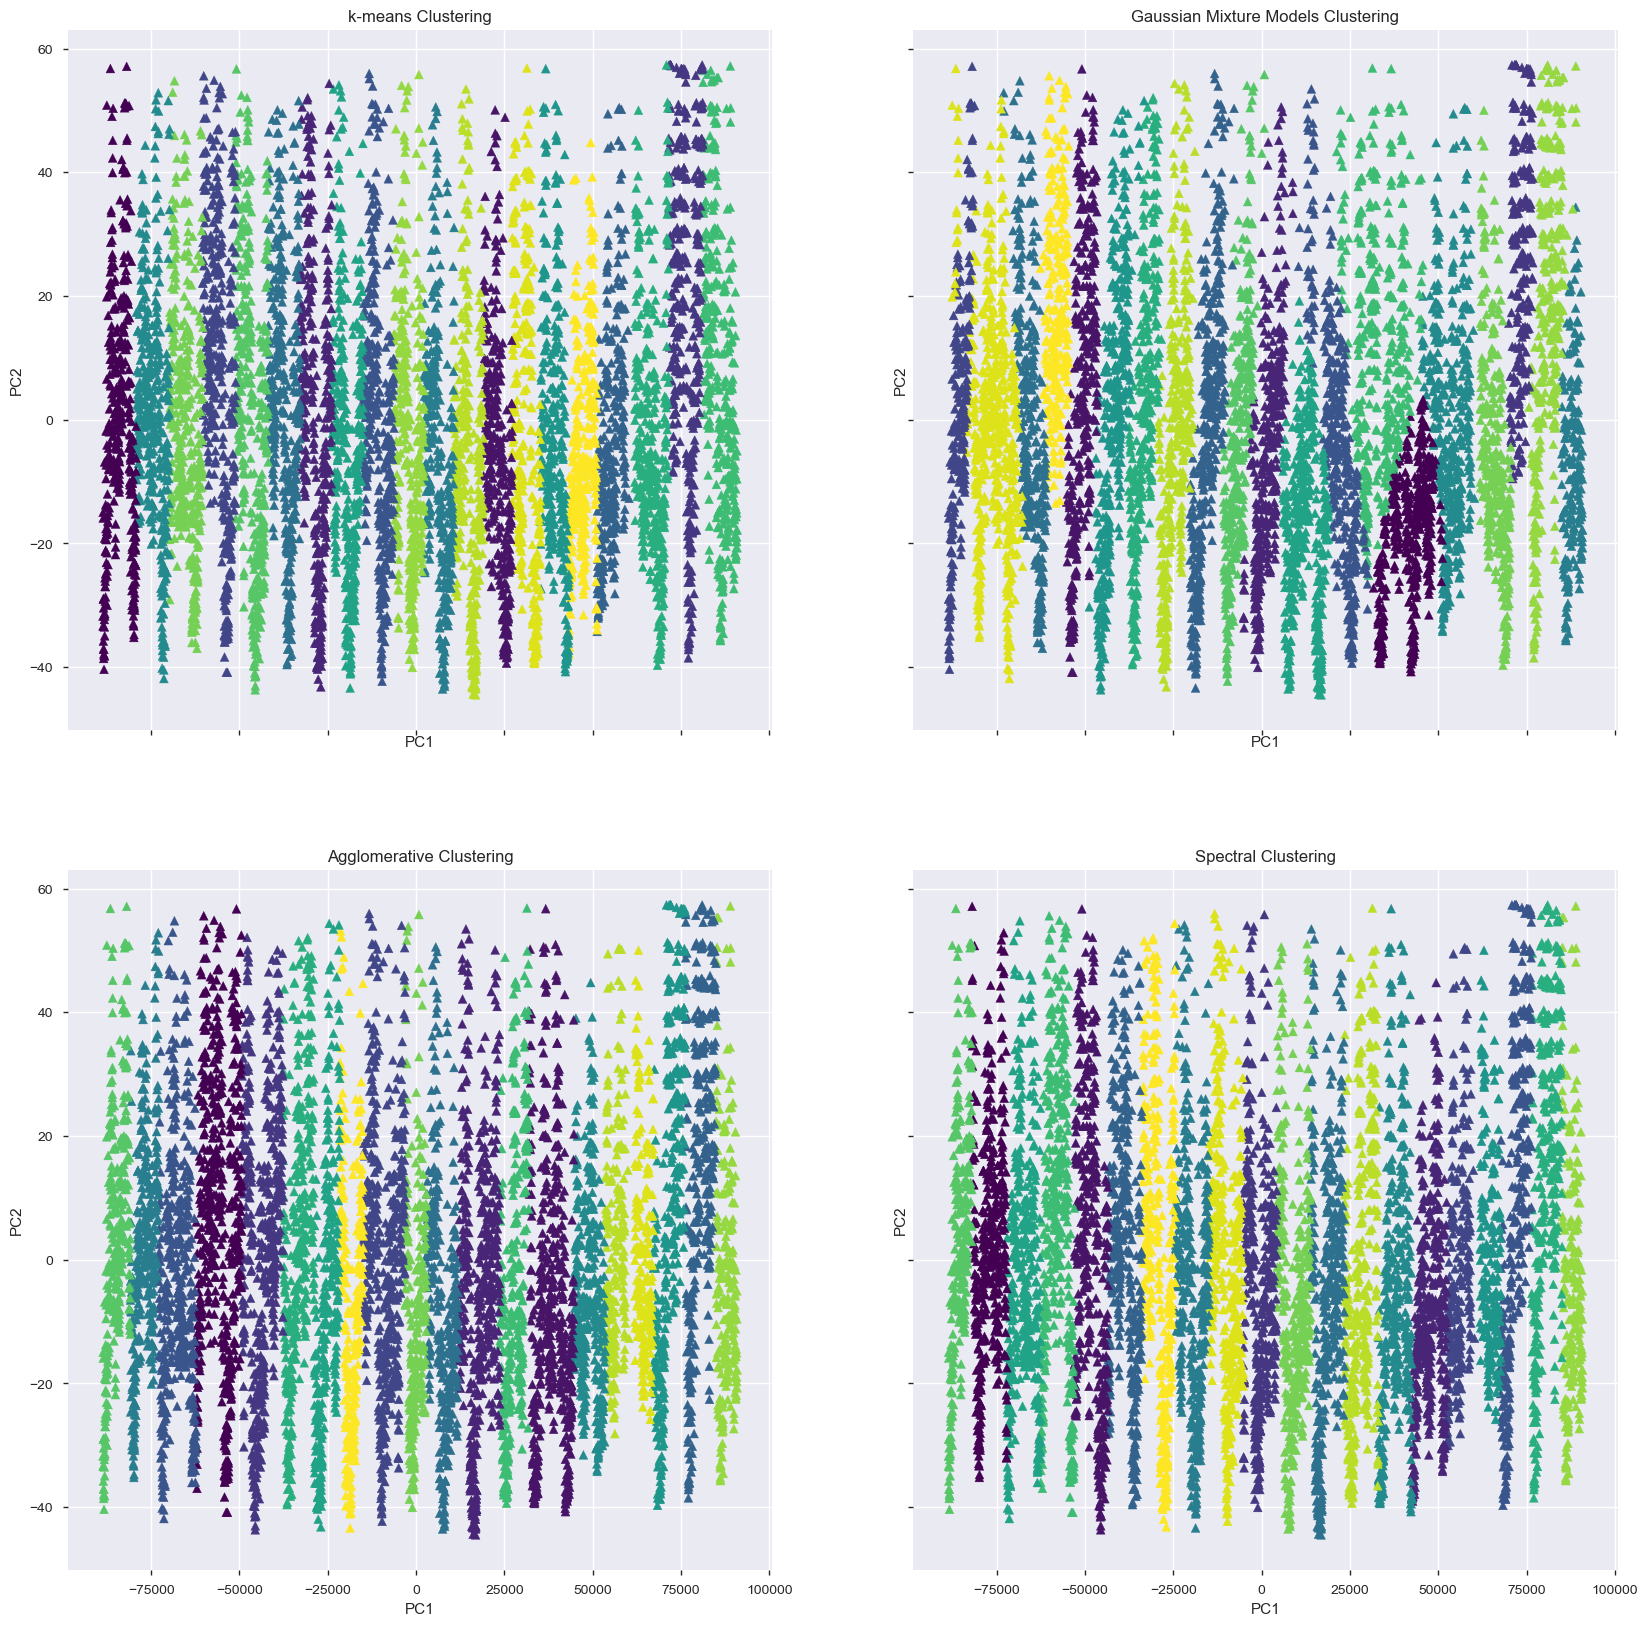

In [46]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(20,20))
ax[0,0].scatter(clusterData[:, 0], clusterData[:, 1], c=kmeansLabels, marker='^', s=40, cmap='viridis')
ax[0,0].set(xlabel='PC1', ylabel='PC2', title='k-means Clustering')
ax[0,1].scatter(clusterData[:, 0], clusterData[:, 1], c=gmmLabels, marker='^', s=40, cmap='viridis')
ax[0,1].set(xlabel='PC1', ylabel='PC2', title='Gaussian Mixture Models Clustering')
ax[1,0].scatter(clusterData[:, 0], clusterData[:, 1], c=aggloLabels, marker='^', s=40, cmap='viridis')
ax[1,0].set(xlabel='PC1', ylabel='PC2', title='Agglomerative Clustering')
ax[1,1].scatter(clusterData[:, 0], clusterData[:, 1], c=spectralLabels, marker='^', s=40, cmap='viridis')
ax[1,1].set(xlabel='PC1', ylabel='PC2', title='Spectral Clustering')
plt.show()

Even after PCA dimensionality reduction, the data is clustered into 20 stripes probably the 20 years. This means that PCA found the most important component to be time, and reduced all other features into PC2.

## Categorical Classification

Try to classify the observations into weather conditions.

In [48]:
x = data[['Dew Point','Humidity','Pressure','Temperature','Visibility','Wind Speed']]
conditions = dict(enumerate(list(data['Condition'].value_counts().keys())))
transfer = {conditions[n]:n for n in range(len(conditions))}
y = np.array([transfer[n] for n in list(data['Condition'])])

### Categorical Classification without PCA

In [49]:
X = data[['Dew Point','Humidity','Pressure','Temperature','Visibility','Wind Speed']]
X = np.array(X)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=int(time.time()))

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
#    "AdaBoost",
    "Naive Bayes"]
#    "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
#    AdaBoostClassifier(),
    GaussianNB()]
#    QuadraticDiscriminantAnalysis()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name + ' Training set score: {:.2f}%'.format(clf.score(X_train, y_train)*100))
    print(name + ' Testing set score: {:.2f}%'.format(clf.score(X_test, y_test)*100))

Nearest Neighbors Training set score: 82.83%
Nearest Neighbors Testing set score: 72.09%
Decision Tree Training set score: 70.72%
Decision Tree Testing set score: 71.30%
Random Forest Training set score: 67.92%
Random Forest Testing set score: 67.68%
Neural Net Training set score: 70.41%
Neural Net Testing set score: 70.34%
Naive Bayes Training set score: 62.79%
Naive Bayes Testing set score: 62.75%


### Categorical Classification with PCA

The number of principle components with the highest ratio of variance to components is 1
Using 1 components will preserve 91.08000000000001% of the data


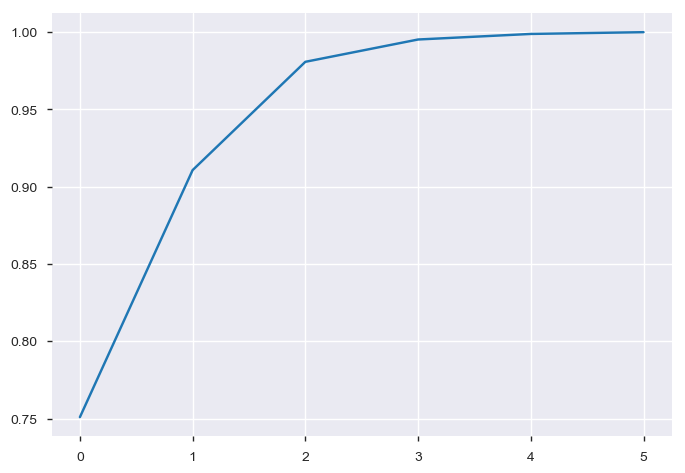

In [50]:
pca = PCA().fit(x)
ratios = np.cumsum(pca.explained_variance_ratio_)
#ratios = temp/(np.arange(len(temp))+1)
maxRatioIndex = 0
for n in range(1,len(ratios)):
    if ratios[n]/(n/len(ratios)+1) > ratios[maxRatioIndex]/(maxRatioIndex/len(ratios)+1):
        maxRatioIndex = n
#ratios = sorted(ratios)
plt.plot (ratios)
print ("The number of principle components with the highest ratio of variance to components is", maxRatioIndex)
print ("Using", maxRatioIndex, "components will preserve", str(100*ratios[maxRatioIndex].round(4)) + "% of the data")
plt.show()

Even though the highest ratio is 1 component, this is not enough so I will use 2.

In [51]:
pca = PCA(n_components=2)
pca.fit(x)
X = pca.transform(x)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=int(time.time()))

Next I will use code from sklearn documentation to test all classification algorithms on this problem.

In [52]:
cmp = plt.cm.get_cmap('viridis', 15)

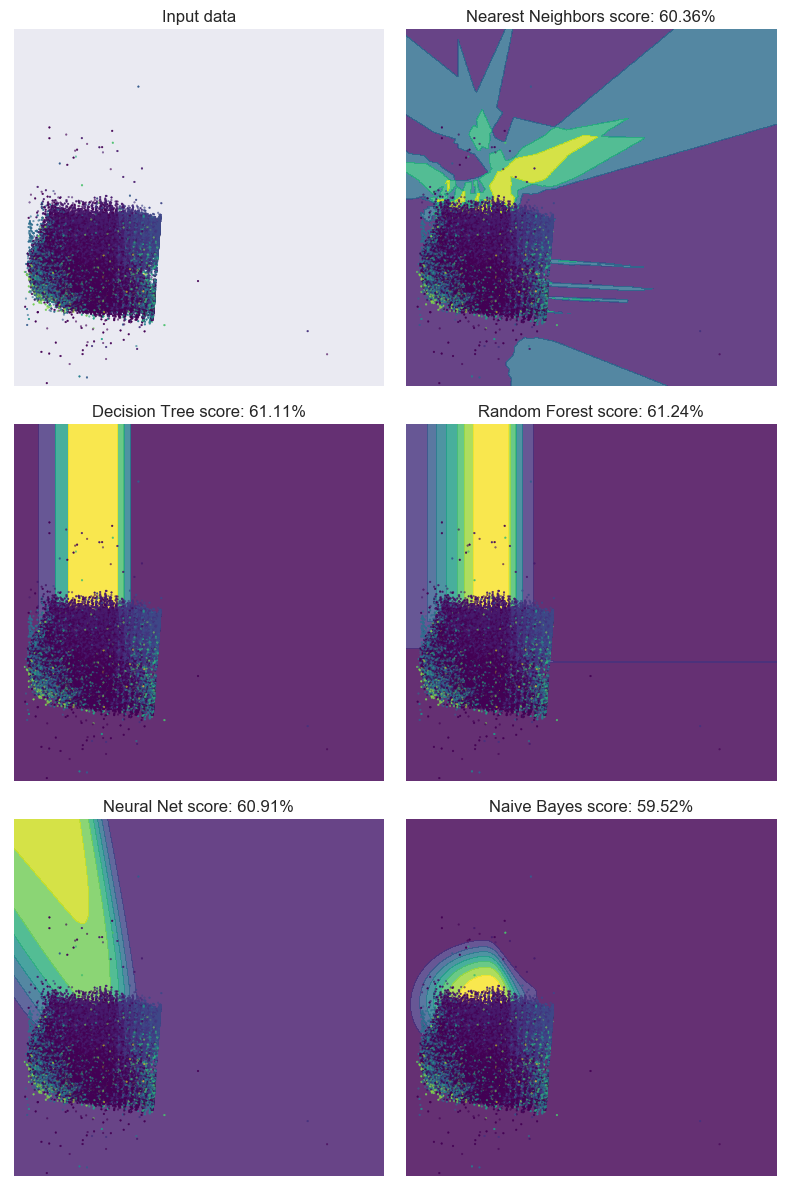

In [53]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8, 12))

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
#    "AdaBoost",
    "Naive Bayes"]
#    "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
#    AdaBoostClassifier(),
    GaussianNB()]
#    QuadraticDiscriminantAnalysis()]

h = .02  # step size in the mesh

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

i = 0

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
ax[int(i/2),i%2].set_title("Input data")
# Plot the training points
ax[int(i/2),i%2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmp, edgecolors='face', s=1.5)
# Plot the testing points
ax[int(i/2),i%2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmp, alpha=0.6, edgecolors='face', s=1.5)
ax[int(i/2),i%2].set_xlim(xx.min(), xx.max())
ax[int(i/2),i%2].set_ylim(yy.min(), yy.max())
ax[int(i/2),i%2].set_xticks(())
ax[int(i/2),i%2].set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax[int(i/2),i%2].contourf(xx, yy, Z, cmap=cmp, alpha=.8)

    # Plot the training points
    ax[int(i/2),i%2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmp, edgecolors='face', s=1.5)
    # Plot the testing points
    ax[int(i/2),i%2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmp, edgecolors='face', alpha=0.6, s=1.5)

    ax[int(i/2),i%2].set_xlim(xx.min(), xx.max())
    ax[int(i/2),i%2].set_ylim(yy.min(), yy.max())
    ax[int(i/2),i%2].set_xticks(())
    ax[int(i/2),i%2].set_yticks(())
    ax[int(i/2),i%2].set_title(name + ' score: {:.2f}%'.format(score*100))
    i += 1

plt.tight_layout()
plt.show()

This classification problem is very hard for these algorithms. KNN finds interesting patterns in the data but none of the scores are good. The different weather conditions are mixed together and separating them is almost impossible for these algorithms. It is interesting that without PCA reduction these algorithms performed more accurately, but are harder to visualize.

## Binary Classification

Try to classify the observations into hot or cold (above average or below average)

In [54]:
x = pd.concat([pd.DataFrame(data.drop(['Date','Temperature','Condition','Fog','Hail','Rain','Thunder'],axis=1)), categories], axis=1)
avgTemp = float(data['Temperature'].sum())/len(data['Temperature'])
# I convert temperature to binary hot or cold by calculating the average temperature
# and dividing the dataset into hotter than average and colder than average.
y = np.array([1 if n < avgTemp else 0 for n in list(data['Temperature'])])

### Binary Classification without PCA

In [59]:
X = StandardScaler().fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=int(time.time()))

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
#    "AdaBoost",
    "Naive Bayes"]
#    "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
#    AdaBoostClassifier(),
    GaussianNB()]
#    QuadraticDiscriminantAnalysis()]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name + ' Training set score: {:.2f}%'.format(clf.score(X_train, y_train)*100))
    print(name + ' Testing set score: {:.2f}%'.format(clf.score(X_test, y_test)*100))

Nearest Neighbors Training set score: 98.14%
Nearest Neighbors Testing set score: 96.43%
Decision Tree Training set score: 93.93%
Decision Tree Testing set score: 93.75%
Random Forest Training set score: 90.25%
Random Forest Testing set score: 90.13%
Neural Net Training set score: 96.37%
Neural Net Testing set score: 96.46%
Naive Bayes Training set score: 47.98%
Naive Bayes Testing set score: 47.48%


### Binary Classification with PCA

The number of principle components with the highest ratio of variance to components is 2
Using 2 components will preserve 98.44000000000001% of the data


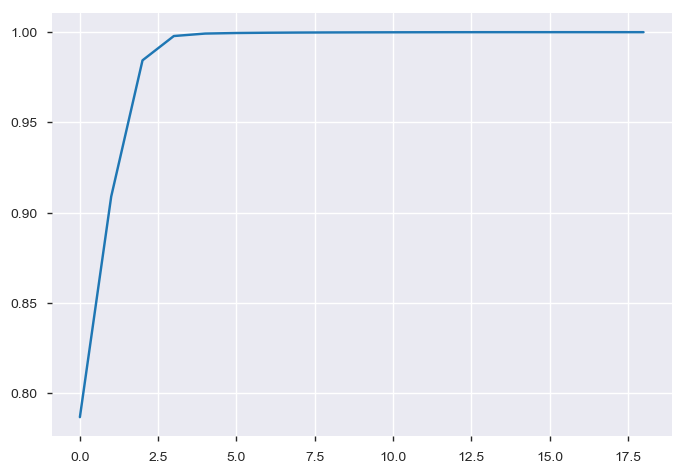

In [55]:
pca = PCA().fit(x)
ratios = np.cumsum(pca.explained_variance_ratio_)
#ratios = temp/(np.arange(len(temp))+1)
maxRatioIndex = 0
for n in range(1,len(ratios)):
    if ratios[n]/(n/len(ratios)+1) > ratios[maxRatioIndex]/(maxRatioIndex/len(ratios)+1):
        maxRatioIndex = n
#ratios = sorted(ratios)
plt.plot (ratios)
print ("The number of principle components with the highest ratio of variance to components is", maxRatioIndex)
print ("Using", maxRatioIndex, "components will preserve", str(100*ratios[maxRatioIndex].round(4)) + "% of the data")
plt.show()

I will use 2 components.

In [56]:
pca = PCA(n_components=2)
pca.fit(x)
X = pca.transform(x)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=int(time.time()))

Next I will use code from sklearn documentation to test all classification algorithms on this problem.

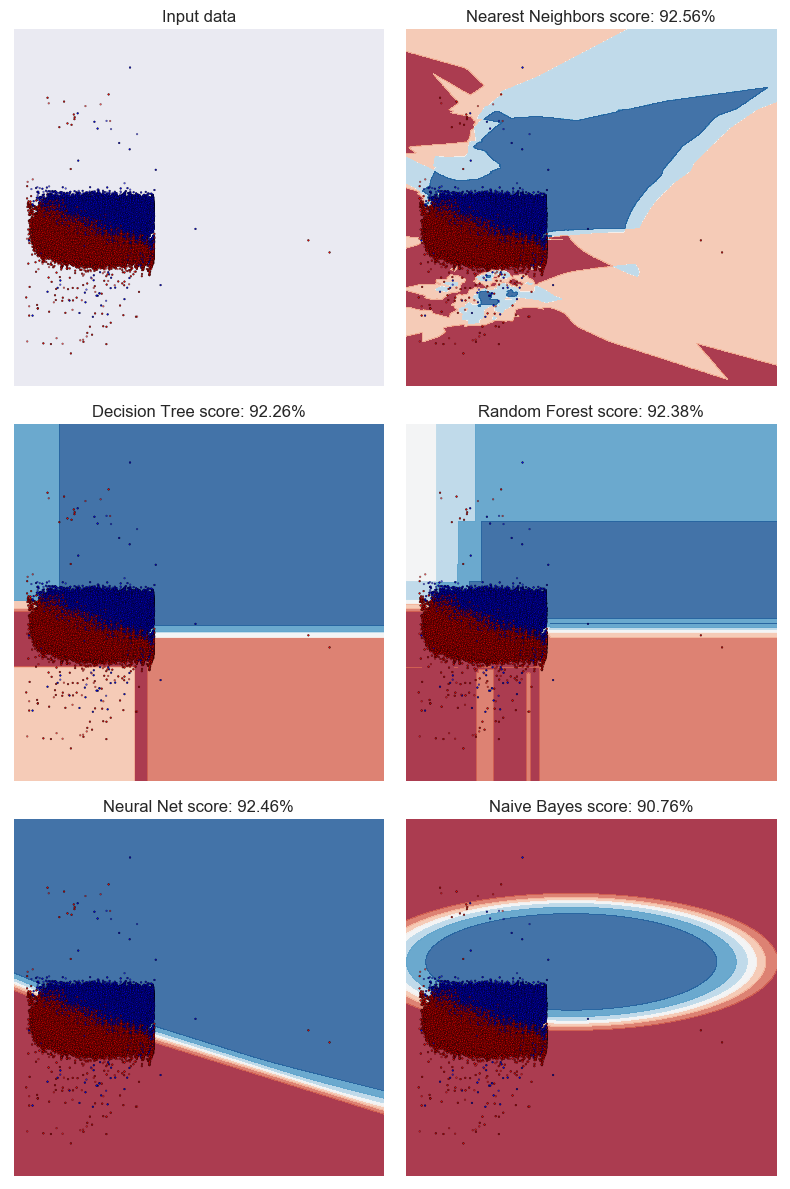

In [57]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8, 12))

cmp = plt.cm.RdBu
cmp_bright = ListedColormap(['#FF0000', '#0000FF'])

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
#    "AdaBoost",
    "Naive Bayes"]
#    "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
#    AdaBoostClassifier(),
    GaussianNB()]
#    QuadraticDiscriminantAnalysis()]

h = .02  # step size in the mesh

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

i = 0

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
ax[int(i/2),i%2].set_title("Input data")
# Plot the training points
ax[int(i/2),i%2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmp_bright, edgecolors='k', s=1.5)
# Plot the testing points
ax[int(i/2),i%2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmp_bright, alpha=0.6, edgecolors='k', s=1.5)
ax[int(i/2),i%2].set_xlim(xx.min(), xx.max())
ax[int(i/2),i%2].set_ylim(yy.min(), yy.max())
ax[int(i/2),i%2].set_xticks(())
ax[int(i/2),i%2].set_yticks(())
i += 1

scoresPCA = {}
# iterate over classifiers
scores = {}
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        scores[name] = clf.decision_function(X_test)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        scores[name] = clf.predict_proba(X_test)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax[int(i/2),i%2].contourf(xx, yy, Z, cmap=cmp, alpha=.8)

    # Plot the training points
    ax[int(i/2),i%2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmp_bright, edgecolors='k', s=1.5)
    # Plot the testing points
    ax[int(i/2),i%2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmp_bright, edgecolors='k', alpha=0.6, s=1.5)

    ax[int(i/2),i%2].set_xlim(xx.min(), xx.max())
    ax[int(i/2),i%2].set_ylim(yy.min(), yy.max())
    ax[int(i/2),i%2].set_xticks(())
    ax[int(i/2),i%2].set_yticks(())
    ax[int(i/2),i%2].set_title(name + ' score: {:.2f}%'.format(score*100))
    i += 1

plt.tight_layout()
plt.show()

The regions underneath the data points are showing where the model would classify points if they existed. These models can classify points in the entire space even though these points are mostly on the left side. I have shown that these models can classify the dataset into hot and cold.

The hot/cold classification problem is much more interesting and it's more easy for these algorithms. They all found good solutions and KNN even found some of the hot points on the bottom. ROC will tell if these are accurate classifiers or not.

### ROC Visualization of Binary Classification

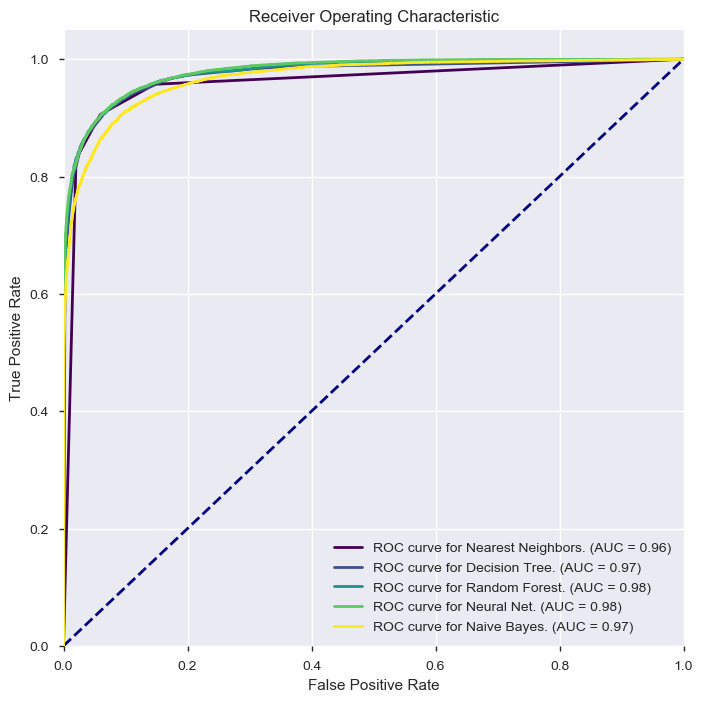

In [58]:
viridis = plt.cm.get_cmap('viridis', len(names))
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

for n, name in enumerate(names):
    fpr, tpr, thresholds = roc_curve(y_test, scores[name][:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=viridis(n), lw=2, label='ROC curve for ' + name + '. (AUC = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.show()

The area under the curve (lower right legend) is equal to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. We want the AUC to be as high as possible because that means the curve is as far to the top left as possible and at the elbow there is a low false positive rate and a high true positive rate.

# Conclusions